Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Random Forest Evaluation (Without Optimization):
Mean Squared Error (MSE): 0.12776470588235295
Mean Absolute Error (MAE): 0.3
R^2 Score: 0.464006452514653
Mean Absolute Percentage Error (MAPE): 747067702893223.5


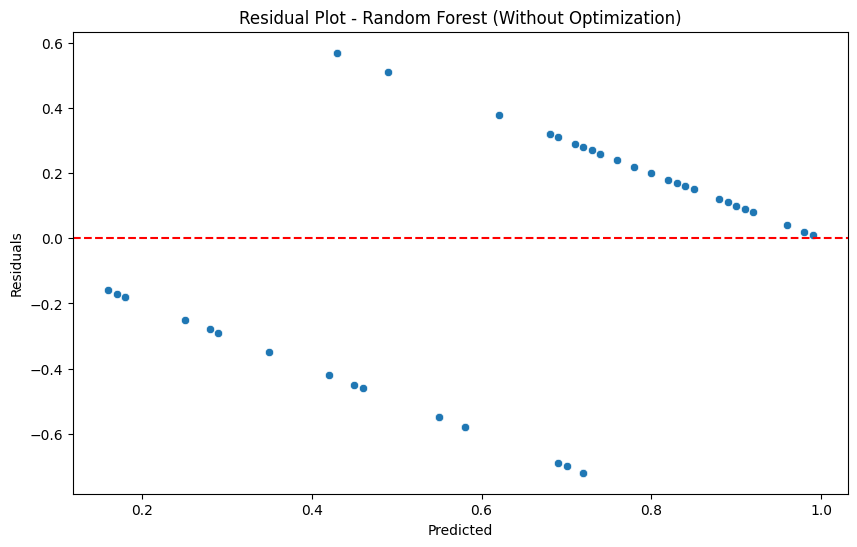

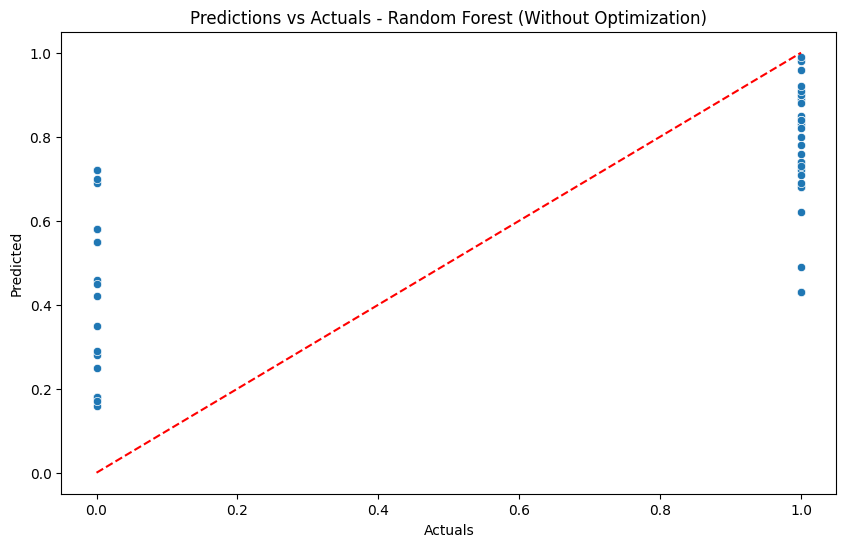

Random Forest Evaluation (With Optimization):
Mean Squared Error (MSE): 0.12006376004518503
Mean Absolute Error (MAE): 0.2924719490940261
R^2 Score: 0.49631316233525813
Mean Absolute Percentage Error (MAPE): 720576411251275.1


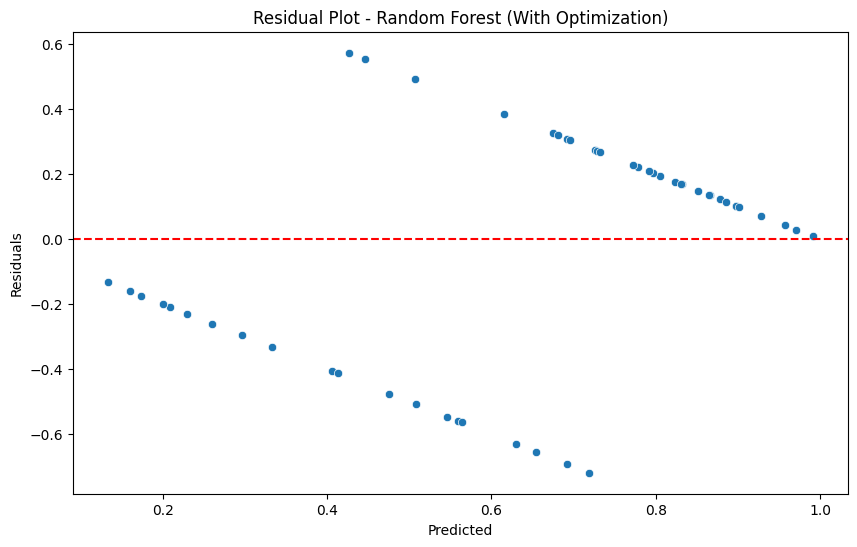

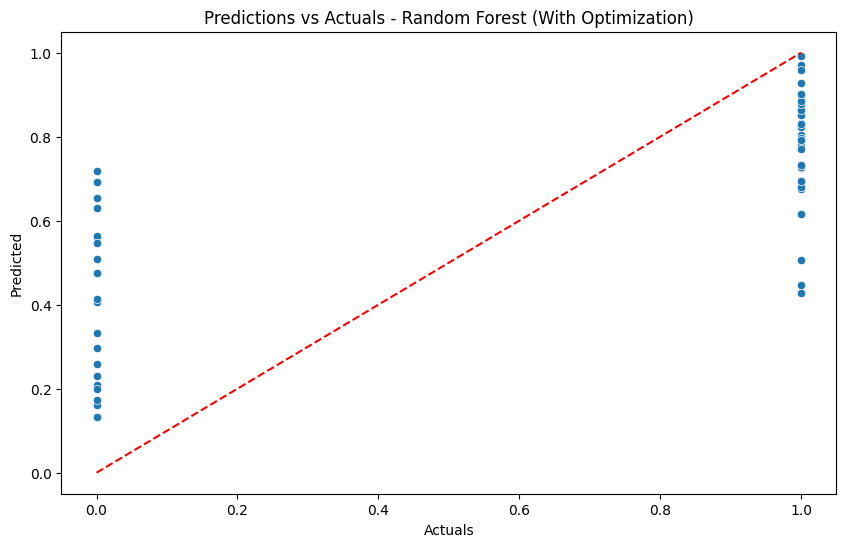

Linear Regression Evaluation:
Mean Squared Error (MSE): 0.11392659693956375
Mean Absolute Error (MAE): 0.25026583671569824
R^2 Score: 0.5220594989592982
Mean Absolute Percentage Error (MAPE): 553481228255232.0


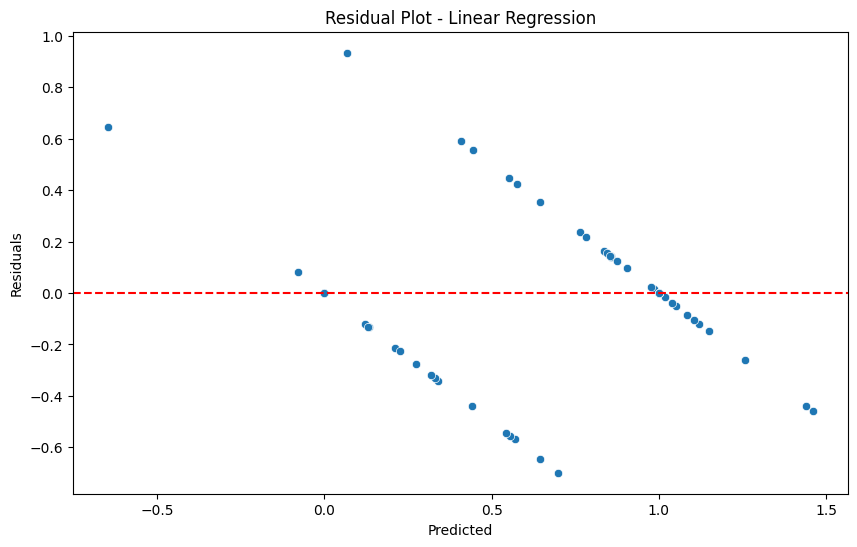

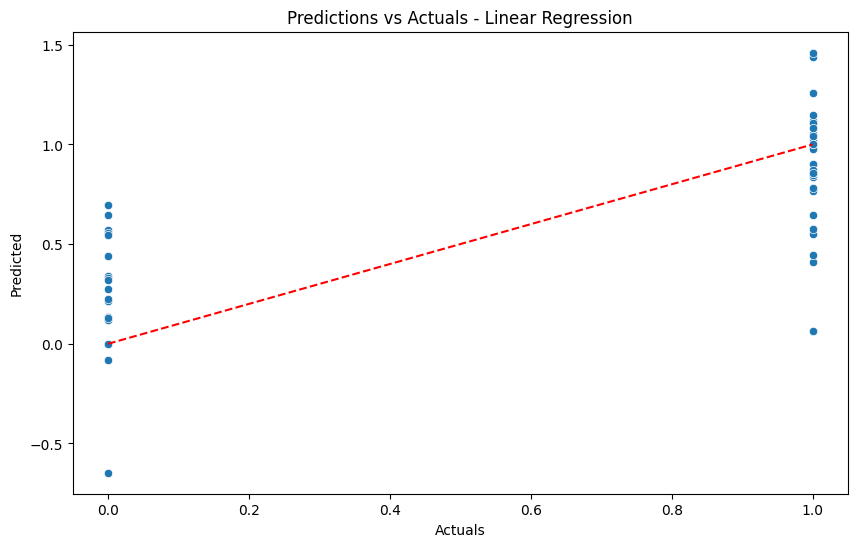

SVM Evaluation (Without Optimization):
Mean Squared Error (MSE): 0.07380991530844684
Mean Absolute Error (MAE): 0.21814392109643244
R^2 Score: 0.6903555009769583
Mean Absolute Percentage Error (MAPE): 538011131544007.06


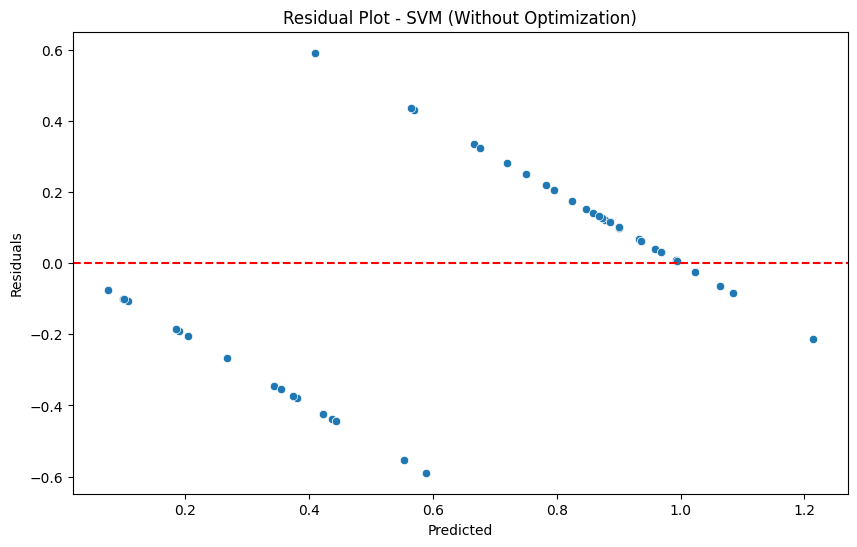

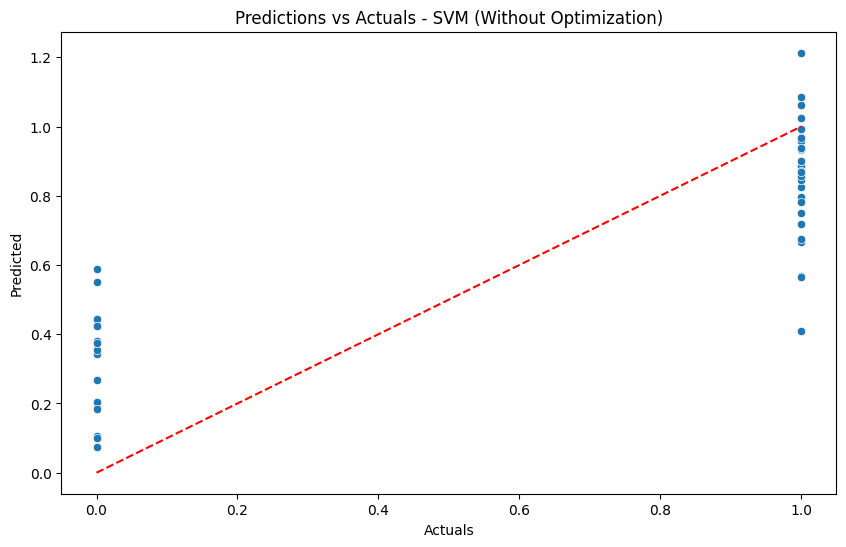

SVM Evaluation (With Optimization):
Mean Squared Error (MSE): 0.06677485212299844
Mean Absolute Error (MAE): 0.20623615946132745
R^2 Score: 0.7198687256778722
Mean Absolute Percentage Error (MAPE): 430741989308444.7


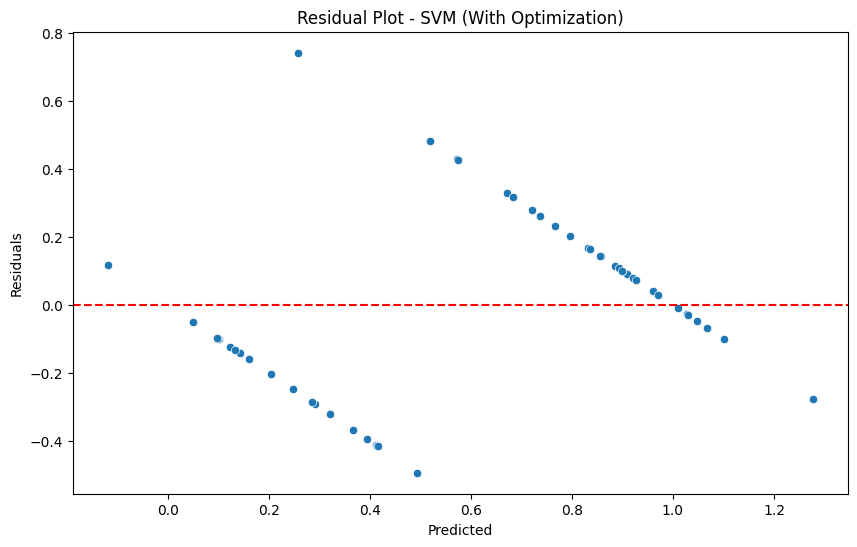

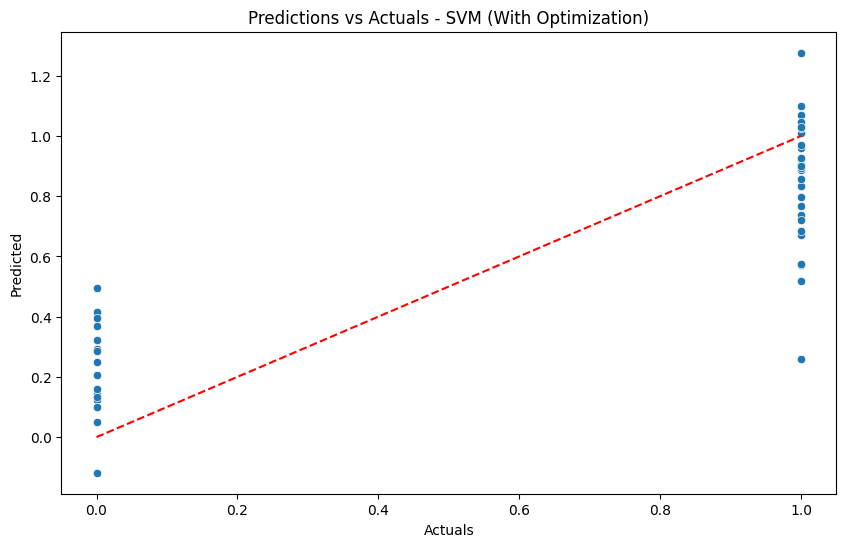

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data loading
def load_data(data_dir, target_size=(224, 224)):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )
    return generator

train_data_dir = "C:/Users/Administrator/Desktop/data/brain_tumor_dataset_split/train"
test_data_dir = "C:/Users/Administrator/Desktop/data/brain_tumor_dataset_split/test"

train_generator = load_data(train_data_dir)
test_generator = load_data(test_data_dir)

# Feature extraction
def build_feature_extractor():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

def extract_features(generator, model):
    features = []
    labels = []
    for batch in generator:
        batch_features = model.predict(batch[0])
        features.append(batch_features)
        labels.extend(batch[1])
        if len(features) * generator.batch_size >= generator.samples:
            break
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

feature_extractor = build_feature_extractor()
X_train, y_train = extract_features(train_generator, feature_extractor)
X_test, y_test = extract_features(test_generator, feature_extractor)

# Snake Optimization Algorithm (modified for regression)
def snake_optimization(objective_function, bounds, num_snakes=5, num_iterations=100):
    dim = len(bounds)
    snakes = np.random.rand(num_snakes, dim)
    for i in range(dim):
        snakes[:, i] = bounds[i][0] + snakes[:, i] * (bounds[i][1] - bounds[i][0])
    
    best_snake = None
    best_score = float('inf')
    
    for iteration in range(num_iterations):
        for snake in snakes:
            # Clamp parameters to their bounds
            snake = np.clip(snake, [b[0] for b in bounds], [b[1] for b in bounds])
            score = objective_function(snake)
            if score < best_score:
                best_score = score
                best_snake = snake
        
        # Update snakes
        for snake in snakes:
            for i in range(dim):
                snake[i] = best_snake[i] + np.random.uniform(-1, 1) * (bounds[i][1] - bounds[i][0]) * 0.1
            # Clamp updated parameters to their bounds
            snake = np.clip(snake, [b[0] for b in bounds], [b[1] for b in bounds])
    
    return best_snake, best_score

# Updated Parameter bounds
bounds_rf = [(50, 150), (3, 10)]
bounds_svm = [(0.1, 10), (1e-5, 1e-3)]

# Objective functions for regressors
def rf_objective_function(params):
    n_estimators, max_depth = int(params[0]), int(params[1])
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def svm_objective_function(params):
    C, gamma = params[0], params[1]
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Optimize hyperparameters using SOA
best_params_rf, _ = snake_optimization(rf_objective_function, bounds_rf)
best_params_svm, _ = snake_optimization(svm_objective_function, bounds_svm)

# Train and evaluate regressors with and without optimization
def train_regressor(model_name, params=None):
    if model_name == 'random_forest':
        if params is not None:
            n_estimators = int(params[0])
            max_depth = int(params[1])
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        else:
            model = RandomForestRegressor(random_state=42)
    elif model_name == 'linear_regression':
        model = LinearRegression()
    elif model_name == 'svm':
        if params is not None:
            C = params[0]
            gamma = params[1]
            model = SVR(C=C, gamma=gamma)
        else:
            model = SVR()
    
    model.fit(X_train, y_train)
    return model

# Function to plot residuals
def plot_residuals(y_true, y_pred, title='Residual Plot'):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()

# Function to plot predictions vs actuals
def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs Actuals'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel('Actuals')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Metrics for evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    
    return mse, mae, r2, mape

# Random Forest
rf_model = train_regressor('random_forest')
rf_predictions = rf_model.predict(X_test)
print("Random Forest Evaluation (Without Optimization):")
evaluate_model(y_test, rf_predictions)
plot_residuals(y_test, rf_predictions, 'Residual Plot - Random Forest (Without Optimization)')
plot_predictions_vs_actuals(y_test, rf_predictions, 'Predictions vs Actuals - Random Forest (Without Optimization)')

optimized_rf_model = train_regressor('random_forest', best_params_rf)
optimized_rf_predictions = optimized_rf_model.predict(X_test)
print("Random Forest Evaluation (With Optimization):")
evaluate_model(y_test, optimized_rf_predictions)
plot_residuals(y_test, optimized_rf_predictions, 'Residual Plot - Random Forest (With Optimization)')
plot_predictions_vs_actuals(y_test, optimized_rf_predictions, 'Predictions vs Actuals - Random Forest (With Optimization)')

# Linear Regression
lr_model = train_regressor('linear_regression')
lr_predictions = lr_model.predict(X_test)
print("Linear Regression Evaluation:")
evaluate_model(y_test, lr_predictions)
plot_residuals(y_test, lr_predictions, 'Residual Plot - Linear Regression')
plot_predictions_vs_actuals(y_test, lr_predictions, 'Predictions vs Actuals - Linear Regression')

# SVM
svm_model = train_regressor('svm')
svm_predictions = svm_model.predict(X_test)
print("SVM Evaluation (Without Optimization):")
evaluate_model(y_test, svm_predictions)
plot_residuals(y_test, svm_predictions, 'Residual Plot - SVM (Without Optimization)')
plot_predictions_vs_actuals(y_test, svm_predictions, 'Predictions vs Actuals - SVM (Without Optimization)')

optimized_svm_model = train_regressor('svm', best_params_svm)
optimized_svm_predictions = optimized_svm_model.predict(X_test)
print("SVM Evaluation (With Optimization):")
evaluate_model(y_test, optimized_svm_predictions)
plot_residuals(y_test, optimized_svm_predictions, 'Residual Plot - SVM (With Optimization)')
plot_predictions_vs_actuals(y_test, optimized_svm_predictions, 'Predictions vs Actuals - SVM (With Optimization)')
